In [3]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

# Ipython magics
%load_ext autoreload
%autoreload 2
# %matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl

# Set some user-specific variables
# MAIN_FOLDER = '../' # relative path to project folder
# FIG_FOLDER = 'figures/' # relative path to figure

# Initializing objects:

In [4]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0
t_end = t_init + 1/24 # 365*5
my_dt = 1/24/20# [days]

spline_order = 3  # actually it is the spline degree
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt, k=spline_order)
print('Sat created')
my_times = np.linspace(t_init, t_end, num=3, endpoint=False)
real_sources = []
calc_sources = []
for t in my_times:
    alpha, delta = generate_observation_wrt_attitude(gaia.func_attitude(t))
    real_src_tmp = Source(str(t),np.degrees(alpha), np.degrees(delta), 0, 0, 0, 0)
    calc_src_tmp = Calc_source('calc_'+str(t), [t], real_src_tmp.get_parameters()[0:5], real_src_tmp.get_parameters()[5])
    real_sources.append(real_src_tmp)
    calc_sources.append(calc_src_tmp)
print('Sources created!')

Sat created
Sources created!


In [5]:
# create Solver
Solver = Agis(gaia, calc_sources, real_sources, attitude_splines=[gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], spline_degree=spline_order,
             attitude_regularisation_factor=1e-0)

In [6]:
len(gaia.s_w.get_knots())

19

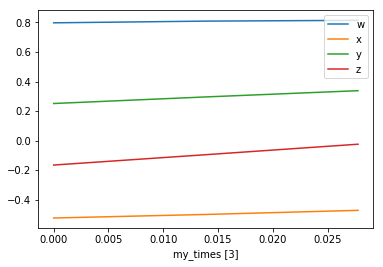

In [7]:
plt.plot(my_times,gaia.s_w(my_times),label="w")
plt.plot(my_times,gaia.s_x(my_times),label="x")
plt.plot(my_times,gaia.s_y(my_times),label="y")
plt.plot(my_times,gaia.s_z(my_times),label="z")
plt.xlabel("my_times [%s]"%len(my_times))
plt.legend()

In [8]:
compute_coeff_basis_sum?

Signature: compute_coeff_basis_sum(coeffs, bases, L, M, time_index)
Docstring:
| Ref. Paper [LUDW2011]_ eq. [80]
| Computes the sum:

.. math::
    \sum_{n=L-M+1}^{L}(a_n \cdot B_n(t_L))

:param coeffs: [numpy array] splines coefficients
:param bases: [numpy array] B-spline bases
:param L: [int] left_index
:param M: [int] spline order (= spline degree + 1)
:param time_index: [float] time index where we want to evaluate the spline
:returns: [numpy array] vector of the
File:      ~/Documents/GitHub/GaiaLab/GaiaLab/scan/analytic_scanner/agis_functions.py
Type:      function


In [9]:
gaia.s_w.get_knots()

array([0.        , 0.00416667, 0.00625   , 0.00833333, 0.01041667,
       0.0125    , 0.01458333, 0.01666667, 0.01875   , 0.02083333,
       0.02291667, 0.025     , 0.02708333, 0.02916667, 0.03125   ,
       0.03333333, 0.03541667, 0.0375    , 0.04166667])

## test0
test that the sources are indeed aligned with the attitude

In [10]:
import astropy.units as u

In [11]:
eta,zeta = calculated_field_angles(calc_sources[0], gaia.func_attitude(my_times[0]), gaia, my_times[0])

In [12]:
np.array([eta,zeta])*u.rad.to(u.mas)

array([-3.43499906e-08, -9.15999748e-08])

OK

## test1 
Test the design and normal matrix

line 366 in agis.py should be checked

dR_da_n = dR_da_i(dR_dq, self.att_bases[:, n_index, obs_time_index])

some times are out of the knots range...

In [13]:
left_index = get_left_index(Solver.att_knots[0], my_times[0], M=Solver.M)

In [14]:
Solver.att_knots[0]

0.0

In [15]:
my_times[:5]

array([0.        , 0.01388889, 0.02777778])

In [16]:
left_index = get_left_index(Solver.att_knots[0], my_times[1], M=Solver.M)

In [17]:
list(Solver.all_obs_times).index(my_times[1])

1

In [20]:
Solver.att_bases.shape

(21, 3)

the normal equation has a strange structure

In [21]:
N_aa = Solver.compute_attitude_LHS()

Text(0.5,1,'$|N_{aa}|$')

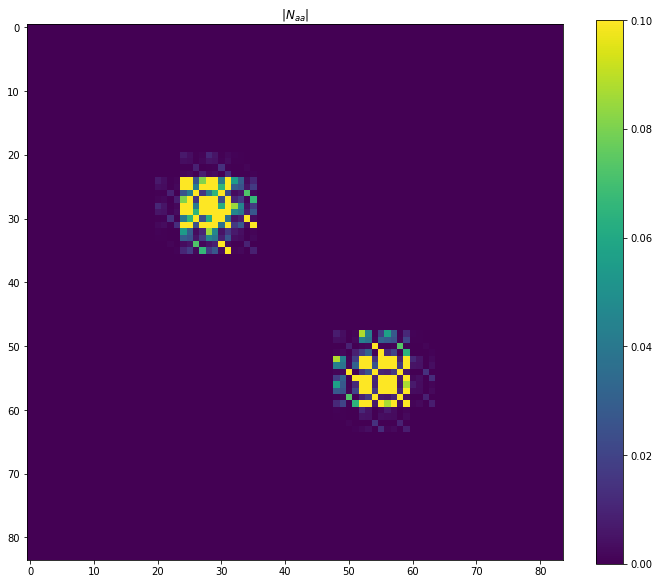

In [22]:
plt.figure(figsize=(12,10))
plt.imshow(np.abs(N_aa),vmax=0.1)
plt.colorbar()
plt.title("$|N_{aa}|$")

In [23]:
eig_vals, eig_vecs = np.linalg.eigh(N_aa)

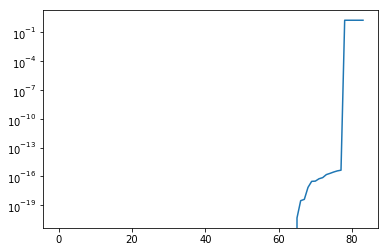

In [24]:
plt.plot(eig_vals)
plt.yscale('log')

/Users/abombrun/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


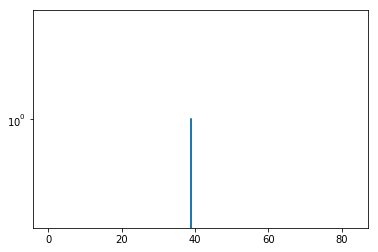

In [25]:
plt.plot(eig_vecs[0])
plt.yscale('log')

/Users/abombrun/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


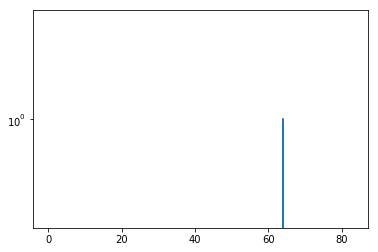

In [26]:
plt.plot(eig_vecs[-1])
plt.yscale('log')

the structure change with the iterations (probably an effect of wrong updates)

In [27]:
Solver.reset_iterations()
Solver.verbose=False
Solver.iterate(3)

Not resetting everything! Call again the solver instead


LinAlgError: Singular matrix